# 3.3.12 断熱位置の入力の年間熱負荷への影響の検証(戸建住宅・144通り)

戸建住戸の断熱位置を入力として得られることを前提としている。
現状の入力パラメータには含まれない要素である。
戸建住戸の断熱位置が入力できることの影響を検証した。

### 必要なモジュールのimport

In [2]:
import os, sys
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

sys.path.append("../experiments")
from common.web_input import create_web_input_from_house_data
from common.house_data import HouseData
from common.utils.func import load_json

### DataFrameを作成

In [9]:
def create_heat_load_dict(
    folder: str,
    index: str,
    model_plan: str,
    main_direction: str,
    region_name: str,
    insulation_level: str,
    structure: str,
) -> dict:
    # 簡易化前(=コントロール群)の暖冷房負荷を取得
    with open(f'{folder}/result_summary_{index}.json', mode='r', encoding='utf-8') as result_json:
        result = json.load(result_json)

    # 簡易化後(=対照群)の暖冷房負荷を取得
    with open(f'{folder}/new_result_summary_{index}.json', mode='r', encoding='utf-8') as result_json_new:
        result_new = json.load(result_json_new)

    # 簡易化前の年間暖房負荷・年間冷房負荷を計算。ただし
    #   * l_s_c_h_sum_MJ: 年間対流空調顕熱負荷(暖房) [MJ]
    #   * l_s_c_c_sum_MJ: 年間対流空調顕熱負荷(冷房) [MJ]
    #   * l_s_r_h_sum_MJ: 年間放射空調顕熱負荷(暖房) [MJ]
    #   * l_s_r_c_sum_MJ: 年間放射空調顕熱負荷(冷房) [MJ]
    #   * l_l_c_h_sum_MJ: 年間対流空調潜熱負荷(暖房) [MJ]
    #   * l_l_c_c_sum_MJ: 年間対流空調潜熱負荷(冷房) [MJ]
    l_h_sum_MJ = result['l_s_c_h_sum_MJ'] + result['l_s_r_h_sum_MJ'] + result['l_l_c_h_sum_MJ']
    l_c_sum_MJ = -(result['l_s_c_c_sum_MJ'] + result['l_s_r_c_sum_MJ'] + result['l_l_c_c_sum_MJ'])

    # 簡易化後の年間暖房負荷・年間冷房負荷を計算。
    l_h_sum_MJ_new = result_new['l_s_c_h_sum_MJ'] + result_new['l_s_r_h_sum_MJ'] + result_new['l_l_c_h_sum_MJ']
    l_c_sum_MJ_new = -(result_new['l_s_c_c_sum_MJ'] + result_new['l_s_r_c_sum_MJ'] + result_new['l_l_c_c_sum_MJ'])

    return {
        '間取り': model_plan,
        '主開口方位': main_direction,
        '地域': region_name,
        '断熱仕様': insulation_level,
        '断熱位置': structure,
        '年間暖房負荷(詳細な入力) [GJ]': l_h_sum_MJ / 1000,
        '年間冷房負荷(詳細な入力) [GJ]': l_c_sum_MJ / 1000,
        '年間暖房負荷(実用的な入力) [GJ]': l_h_sum_MJ_new / 1000,
        '年間冷房負荷(実用的な入力) [GJ]': l_c_sum_MJ_new / 1000,
    }


def create_heat_load_df(folder:str) -> pd.DataFrame:
    with open(f'{folder}/index.csv', mode='r', encoding='utf-8', newline='') as index_csv:
        index_csv_reader = csv.reader(index_csv)
        next(index_csv_reader)  # ヘッダ行をスキップ
        heat_load_dicts = [create_heat_load_dict(folder, *_) for _ in index_csv_reader]
    return pd.DataFrame(heat_load_dicts)


# 断熱位置を考慮しない場合
heat_load_df1 = create_heat_load_df('result_kodate_yukadannetsu')

# 断熱位置を考慮する場合
heat_load_df2 = create_heat_load_df('result_kodate')


### グラフの描画

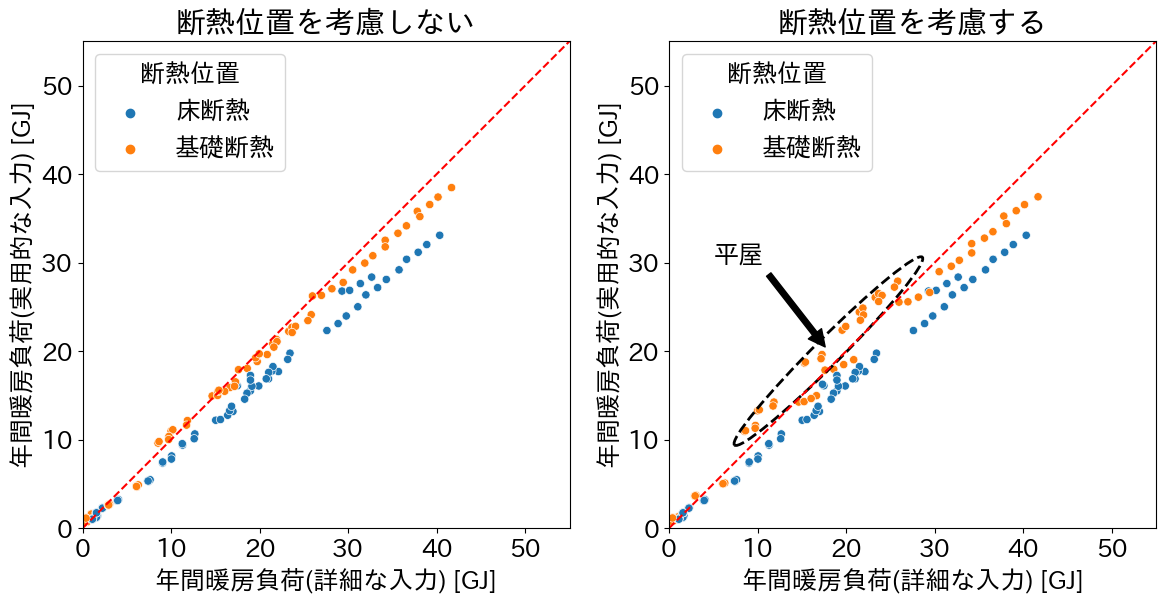

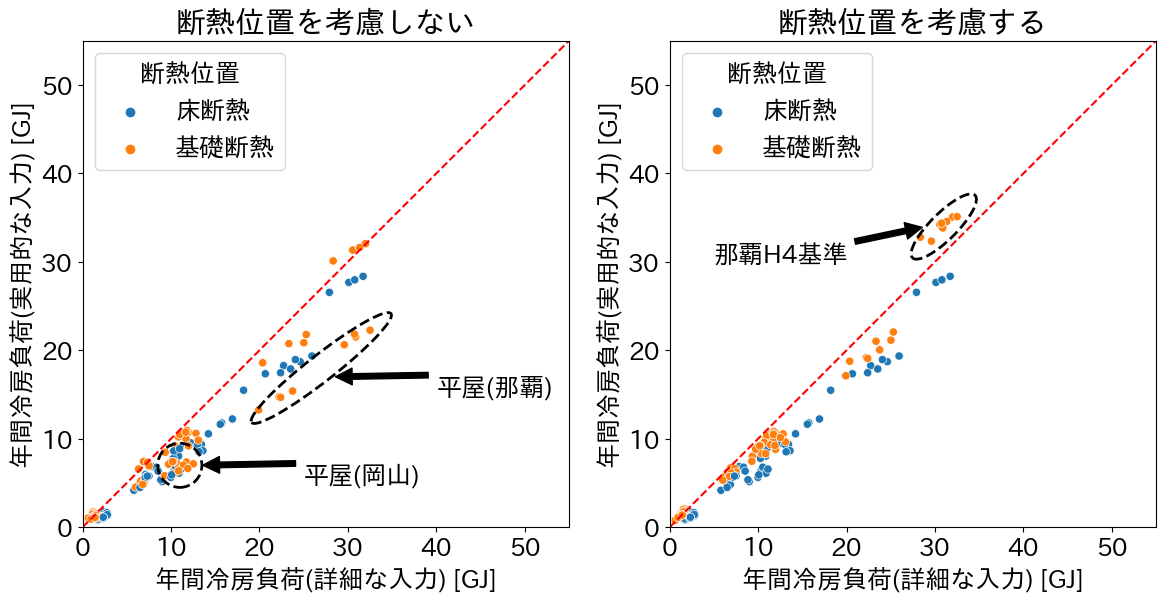

In [12]:
from matplotlib.patches import Ellipse

def plot(col:str):
    hue = '断熱位置'

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # データフレームのコピーを作成（元のデータを保持）
    df1 = heat_load_df1[heat_load_df1['断熱位置'] != '無'].copy()
    df2 = heat_load_df2[heat_load_df2['断熱位置'] != '無'].copy()

    plt.rcParams['font.size'] = 18

    sns.scatterplot(df1, x=f'年間{col}負荷(詳細な入力) [GJ]', y=f'年間{col}負荷(実用的な入力) [GJ]', hue=hue, ax=axes[0])
    axes[0].set_title('断熱位置を考慮しない')
    axes[0].set_xlim([0, 55.0])
    axes[0].set_ylim([0, 55.0])
    axes[0].set_aspect('equal')
    axes[0].plot([0, 55.0], [0, 55.0], 'r--')   # X=Y の線を描く

    sns.scatterplot(df2, x=f'年間{col}負荷(詳細な入力) [GJ]', y=f'年間{col}負荷(実用的な入力) [GJ]', hue=hue, ax=axes[1])
    axes[1].set_title('断熱位置を考慮する')
    axes[1].set_xlim([0, 55.0])
    axes[1].set_ylim([0, 55.0])
    axes[1].set_aspect('equal')
    axes[1].plot([0, 55.0], [0, 55.0], 'r--')   # X=Y の線を描く

    if col == '暖房':
        # 平屋の注釈
        ellipse = Ellipse(xy=(18, 20), width=3, height=30, angle=-45, linestyle='--', edgecolor='black', fc='None', lw=2)
        axes[1].add_patch(ellipse)
        axes[1].annotate('平屋', xy=(18, 20), xytext=(5, 30),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    fontsize=18, color='black')
    elif col == '冷房':
        # 平屋(岡山)の注釈
        ellipse = Ellipse(xy=(11, 7), width=5, height=5, linestyle='--', edgecolor='black', fc='None', lw=2)
        axes[0].add_patch(ellipse)
        axes[0].annotate('平屋(岡山)', xy=(13, 7), xytext=(25, 5),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    fontsize=18, color='black')

        # 平屋(那覇)の注釈
        ellipse = Ellipse(xy=(27, 18), width=3, height=20, angle=-52, linestyle='--', edgecolor='black', fc='None', lw=2)
        axes[0].add_patch(ellipse)
        axes[0].annotate('平屋(那覇)', xy=(28, 17), xytext=(40, 15),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    fontsize=18, color='black')

        # 那覇H4基準の注釈
        ellipse = Ellipse(xy=(31, 34), width=3, height=10, angle=-45, linestyle='--', edgecolor='black', fc='None', lw=2)
        axes[1].add_patch(ellipse)
        axes[1].annotate('那覇H4基準', xy=(29, 34), xytext=(5, 30),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    fontsize=18, color='black')

    plt.tight_layout()

plot('暖房')
plot('冷房')
